# IMPORTING LIBRARIES

In [1]:
import matplotlib.pyplot as plt
from skimage.feature import hog
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, Average
from tensorflow.keras.layers import concatenate, Concatenate
import tqdm
import os
import re
import cv2

# LOADING TRAIN, VAL & TEST DATA

In [2]:
train = np.load("train.npz")

In [3]:
test = np.load("test.npz")

In [4]:
val = np.load("val.npz")

In [14]:
train['data'].shape

(35187, 128, 128, 3)

In [ ]:
test['data'].shape

(10996, 128, 128, 3)

In [ ]:
val['data'].shape

(8797, 128, 128, 3)

In [19]:
train['data'][0].shape

(128, 128, 3)

# CREATING HOG FEATURES

In [5]:
train_hog = np.array([hog(instance, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(3, 3), channel_axis=-1) for instance in tqdm.tqdm(train['data'])])

100%|████████████████████████████████████████████████████████████████████████████| 35187/35187 [07:07<00:00, 82.29it/s]


In [6]:
val_hog = np.array([hog(instance, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(3, 3),channel_axis=-1) for instance in tqdm.tqdm(val['data'])])

100%|██████████████████████████████████████████████████████████████████████████████| 8797/8797 [01:45<00:00, 83.17it/s]


In [21]:
test_hog = np.array([hog(instance, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(3, 3),channel_axis=-1) for instance in tqdm.tqdm(test['data'])])


 10%|███████▊                                                                     | 1113/10996 [00:14<02:07, 77.61it/s]


 20%|███████████████▌                                                             | 2226/10996 [00:28<01:51, 78.82it/s]


 30%|███████████████████████▍                                                     | 3339/10996 [00:42<01:35, 80.54it/s]


 41%|███████████████████████████████▎                                             | 4477/10996 [00:56<01:25, 76.04it/s]


 51%|███████████████████████████████████████                                      | 5579/10996 [01:10<01:08, 79.47it/s]


 61%|██████████████████████████████████████████████▊                              | 6690/10996 [01:24<00:54, 78.50it/s]


 71%|██████████████████████████████████████████████████████▋                      | 7803/10996 [01:38<00:40, 78.16it/s]


 81%|██████████████████████████████████████████████████████████████▎              | 8905/10996 [01:52<00:25, 80.99it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 10009/10996 [02:06<00:12, 77.50it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10996/10996 [02:19<00:00, 78.79it/s]


# LOADING CONCATENATED MODEL

In [7]:
concat_model = load_model("concatenated_model.h5")

In [8]:
concat_model.summary()

Model: "ensemble_m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']    

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 lization)                                                                                        
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 block2_sepconv2_act (Activatio  (None, 61, 61, 128)  0          ['block2_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 block2_se

 conv3_block3_add (Add)         (None, 16, 16, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 block4_sepconv1_act (Activatio  (None, 16, 16, 256)  0          ['add_1[0][0]']                  
 n)                                                                                               
                                                                                                  
 conv3_block3_out (Activation)  (None, 16, 16, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 block4_sepconv1 (SeparableConv  (None, 16, 16, 728)  188672     ['block4_sepconv1_act[0][0]']    
 2D)                                                                                              
          

 n)                                                                                               
                                                                                                  
 block5_sepconv3_act (Activatio  (None, 8, 8, 728)   0           ['block5_sepconv2_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 block5_sepconv3 (SeparableConv  (None, 8, 8, 728)   536536      ['block5_sepconv3_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 block7_sepconv1_act (Activatio  (None, 8, 8, 728)   0           ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block8_sepconv2_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block8_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 block8_sepconv3_act (Activatio  (None, 8, 8, 728)   0           ['block8_sepconv2_bn[0][0]']     
 n)       

                                                                  'add_6[0][0]']                  
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block11_sepconv2_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block11_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
          

 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
          

 block14_sepconv2_bn (BatchNorm  (None, 4, 4, 2048)  8192        ['block14_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block3_out (Activation)  (None, 4, 4, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 block14_sepconv2_act (Activati  (None, 4, 4, 2048)  0           ['block14_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
          

# EXTRACTING CONCATENATED LAYER

In [9]:
concat_layer = concat_model.get_layer('concatenated_layer').output

# CREATING MODEL USING HOG FEATURES

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(train_hog[0].shape[0],), name='hog_feature_input'))
model.add(tf.keras.layers.Dense(512, activation='relu', name='hog_layer'))

# EXTRACTING LAYER FROM HOG MODEL

In [11]:
hog_layer = model.get_layer('hog_layer').output

# CONCATENATING CONCAT LAYER AND HOG LAYER

In [12]:
merged_layers = concatenate([concat_layer, hog_layer], name="concatenated_hog_layer")
merged_layers

<KerasTensor: shape=(None, 2560) dtype=float32 (created by layer 'concatenated_hog_layer')>

# ADDING DENSE AND OUTPUT LAYER

In [13]:
output = tf.keras.layers.Dense(256, activation='relu')(merged_layers)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

# MODEL CREACTION

In [15]:
merged_model = tf.keras.Model(inputs=[(concat_model.input, model.input)],outputs=[output], name = "res_excep_hog")

In [16]:
merged_model.summary()

Model: "res_excep_hog"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]'] 

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 lization)                                                                                        
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 block2_sepconv2_act (Activatio  (None, 61, 61, 128)  0          ['block2_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 block2_se

 conv3_block3_add (Add)         (None, 16, 16, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 block4_sepconv1_act (Activatio  (None, 16, 16, 256)  0          ['add_1[0][0]']                  
 n)                                                                                               
                                                                                                  
 conv3_block3_out (Activation)  (None, 16, 16, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 block4_sepconv1 (SeparableConv  (None, 16, 16, 728)  188672     ['block4_sepconv1_act[0][0]']    
 2D)                                                                                              
          

 n)                                                                                               
                                                                                                  
 block5_sepconv3_act (Activatio  (None, 8, 8, 728)   0           ['block5_sepconv2_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 block5_sepconv3 (SeparableConv  (None, 8, 8, 728)   536536      ['block5_sepconv3_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 block7_sepconv1_act (Activatio  (None, 8, 8, 728)   0           ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block8_sepconv2_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block8_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 block8_sepconv3_act (Activatio  (None, 8, 8, 728)   0           ['block8_sepconv2_bn[0][0]']     
 n)       

                                                                  'add_6[0][0]']                  
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block11_sepconv2_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block11_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
          

 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
          

 block14_sepconv2_bn (BatchNorm  (None, 4, 4, 2048)  8192        ['block14_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 conv5_block3_out (Activation)  (None, 4, 4, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 block14_sepconv2_act (Activati  (None, 4, 4, 2048)  0           ['block14_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
          

# MODEL ARCHITECTURE

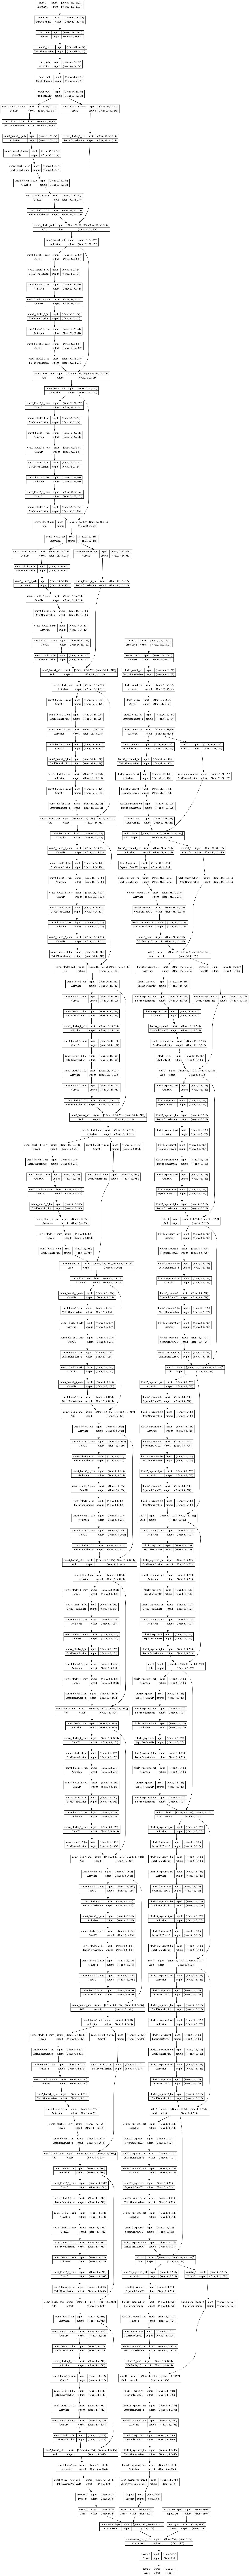

In [17]:
plot_model(merged_model, "HOG_architecture.png", show_shapes=True)

# MODEL COMPILING

In [18]:
merged_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# MODEL TRAINING

In [19]:
merged_model.fit([[train['data'], train['data']], train_hog], train['labels'],
                 validation_data=([[val['data'], val['data']], val_hog], val['labels']), 
                 epochs=10, batch_size=512)

Epoch 1/10
69/69 [==============================] - 1574s 23s/step - loss: 0.2797 - accuracy: 0.9111 - val_loss: 0.2629 - val_accuracy: 0.9258
Epoch 2/10
69/69 [==============================] - 1333s 19s/step - loss: 0.1635 - accuracy: 0.9486 - val_loss: 0.1249 - val_accuracy: 0.9617
Epoch 3/10
69/69 [==============================] - 1003s 15s/step - loss: 0.1145 - accuracy: 0.9646 - val_loss: 0.1050 - val_accuracy: 0.9728
Epoch 4/10
69/69 [==============================] - 1006s 15s/step - loss: 0.1016 - accuracy: 0.9701 - val_loss: 0.0753 - val_accuracy: 0.9791
Epoch 5/10
69/69 [==============================] - 1000s 15s/step - loss: 0.0749 - accuracy: 0.9791 - val_loss: 0.0622 - val_accuracy: 0.9856
Epoch 6/10
69/69 [==============================] - 999s 15s/step - loss: 0.0549 - accuracy: 0.9847 - val_loss: 0.0387 - val_accuracy: 0.9928
Epoch 7/10
69/69 [==============================] - 995s 14s/step - loss: 0.0429 - accuracy: 0.9889 - val_loss: 0.0383 - val_accuracy: 0.9906
E

# EVALIATING USING TEST DATA

In [22]:
test_scores = merged_model.evaluate([[test['data'], test['data']], test_hog], test['labels'])

344/344 [==============================] - 403s 1s/step - loss: 0.0268 - accuracy: 0.9925


# TEST ACCURACY

In [23]:
test_scores[1]

0.9925427436828613